# COMP47590: Advanced Machine Learning
# Assignment 1: The Super Learner

## Import Packages Etc

In [21]:
from IPython.display import display, HTML, Image
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin  # 6 Base Classifiers for stacked ensemble 
from sklearn.naive_bayes import GaussianNB               # Naive Bayes
from sklearn.tree import DecisionTreeClassifier          # Decision Tree
from sklearn.neural_network import MLPClassifier         # Multi-layer Perceptron
from sklearn import svm                                  # Support vector Machine
from sklearn import linear_model                         # Logistic Regression
from sklearn import neighbors                            # K-Nearest Neighbours
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils.validation import check_is_fitted
from sklearn import neural_network
import matplotlib.pyplot as plt
from matplotlib import pyplot

%matplotlib inline
#%qtconsole

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007) and the process is also described in the COMP47590 lecture "[COMP47590 2017-2018 L04 Supervised Learning Ensembles 3](https://www.dropbox.com/s/1ksx94nxtuyn4l8/COMP47590%202017-2018%20L04%20Supervised%20Learning%20Ensembles%203.pdf?raw=1)"). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

In [75]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregation model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
   ClassifierMixin : array of base classifiers for stacked ensemble 
        
    Attributes
    ----------
    


    Notes
    -----
    

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = SuperLearnerClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
        
    # Constructor for the classifier object
    def __init__(self,stackClassifier=DecisionTreeClassifier(criterion="entropy",max_depth=24,min_samples_split=200),\
            baseClassifiers=[DecisionTreeClassifier(criterion="entropy",max_depth=24,\
            min_samples_split=200),linear_model.LogisticRegression(C=0.2,max_iter=1000,multi_class="ovr",solver="liblinear"),\
            MLPClassifier(alpha=0.1,hidden_layer_sizes=(400, 200, 100)),svm.SVC(C=10,gamma=0.01,probability=True),\
            neighbors.KNeighborsClassifier(n_neighbors=6),GaussianNB()],useBaseProb=False,addOriginalData=False,base_folds=5):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        stackClassifier : sklearn-classifier, the stack layer classifier to use
        baseClassifiers : array of sklearn classifiers, list of base classifiers for the ensemble
        useBaseProb     : Boolean, whether to use probablity distribution for stack layer instead of class labels 
        addOriginalData : Boolean, add original training data to output of base layer
        base_folds      : integer, number of k-folds to train the ensemble layer
        
        Returns
        -------

        """     
        self.stackClassifier=stackClassifier
        self.baseClassifiers=baseClassifiers
        self.useBaseProb=useBaseProb
        self.addOriginalData=addOriginalData
        self.base_folds=base_folds
        self.sl_train=pd.DataFrame()
    
    #Train the base classifiers and generate training data for stack layer classifier
    def __ensembleLayer__(self,X,y):
        # Split the data into k stratified folds for uniform distribution
        skf = StratifiedKFold(n_splits=self.base_folds)
        
        # if useBaseProb is False, use class labels to train stack layer, 
        # else use probablity distributions to train stack layer
        if not self.useBaseProb:
            # train all base classifiers on each fold
            for train_index, test_index in skf.split(X,y):
                baseLabels=pd.DataFrame()
                baseLabels['target']=y[test_index]

                for counter, value in enumerate(self.baseClassifiers):
                    value.fit(X.iloc[train_index],y[train_index])
                    baseLabels['{}{}'.format('C', counter)]=value.predict(X.iloc[test_index])
                # if addOriginalData is True, add the original training to 
                # the output of baseclassifiers to train stack layer
                if self.addOriginalData:
                    x=X.iloc[test_index].reset_index(drop=True)
                    baseLabels=pd.concat([baseLabels,x],axis=1)

                # Construct the training set for stack layer from predictions of each fold
                self.sl_train=self.sl_train.append(baseLabels)
        else:
            # Use probablity distribution to train stack layer
            for train_index, test_index in skf.split(X,y):
                
                classProb=pd.DataFrame()
                classProb['target']=y[test_index]
                for counter, value in enumerate(self.baseClassifiers):
                    j=1
                    value.fit(X.iloc[train_index],y[train_index])
                    prob=value.predict_proba(X.iloc[test_index])
                    for c in np.hsplit(prob, prob.shape[1]):
                        classProb['{}{}{}'.format('p',counter,j)]=c
                        j+=1
                if self.addOriginalData:
                        x=X.iloc[test_index].reset_index(drop=True)
                        baseLabels=pd.concat([baseLabels,x],axis=1)
                
                self.sl_train=self.sl_train.append(classProb)
        
        # Retrain all base classifiers on the entire training set
        for counter, value in enumerate(self.baseClassifiers):
            value.fit(X,y)
        return self
    
    # Function to train the stack layer classifier on the output of __ensemble_layer__
    def __stackLayer__(self,X):
        self.stackClassifier.fit(self.sl_train[self.sl_train.columns[1:]],np.array(self.sl_train["target"]))
        return self
    
    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """ 
        # Check if training set is a dataframe, if not, convert to dataframe
        if not isinstance(X, pd.DataFrame):
            X=pd.DataFrame(X)
            
        # Call ensemble layer and stack layer functions to fit the superlearner
        self.__ensembleLayer__(X,y)
        self.__stackLayer__(X)              
                    
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        # Check if X is a dataframe, if not, convert to dataframe
        if not isinstance(X, pd.DataFrame):
            X=pd.DataFrame(X)
            
        # check if fit function has been called before predicting
        check_is_fitted(self,['stackClassifier','baseClassifiers','useBaseProb','addOriginalData','base_folds'])
        
        # create empty dataframe to store predictions of base layer
        sl_input=pd.DataFrame()
        
        # if baseProbablity is not used, predict class labels and add it to training data for stack layer
        if not self.useBaseProb:    
            for counter, value in enumerate(self.baseClassifiers):
                sl_input['{}{}'.format('C', counter)]=value.predict(X)
                
        # if baseProbability is used, predict class probabilities and add it to training data for stack layer
        else:
            for counter, value in enumerate(self.baseClassifiers):
                    k=1
                    prob=value.predict_proba(X)
                    for c in np.hsplit(prob, prob.shape[1]):
                        sl_input['{}{}{}'.format('p',counter,k)]=pd.Series(c.flatten())
                        k+=1
                        
        # Check if the original training set has to be added to the stack layer training set
        if self.addOriginalData:
            X=X.reset_index(drop=True)                
            sl_input=pd.concat([sl_input,X],axis=1)
            
        # Return the predictions from the superlearner
        return self.stackClassifier.predict(sl_input)
    
    #Function to analyse the accuracy and diversity of the base estimators
    def get_ensemble_strength(self,X,y):
        """
        Find accuracy of all the models of the base estimators individually to predict classifier strength.
        Find the similarity of the predictions made by each estimator. 
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        ensemble_accuracy   : Dictionary of accuracies of individual ensemble classifiers
        matrix_diversity   : Pair-wise euclidean distance between confusion matrices of ensemble classifiers
        diagonal_diversity : Pair-wise euclidean distance between the number of true positives of ensemble classifiers
                             
        """
        # Check if training set is a dataframe, if not, convert to dataframe
        if not isinstance(X, pd.DataFrame):
            X=pd.DataFrame(X)
        #count number of class labels and base estimators
        labels=len(np.unique(y))
        n_classifiers=len(self.baseClassifiers)
        #Create a hold out set for testing base estimators
        X_train, X_hold, y_train, y_hold  = train_test_split(X, Y, random_state=0, train_size = 0.7)
        #Create dictionary to store accuracies
        ensemble_accuracy=dict()
        stack_train_set=pd.DataFrame()
        skf = StratifiedKFold(n_splits=self.base_folds)
        
        #Initialise each classifier accuracy to 0 for future aggregating and averaging after cross validation
        for counter, value in enumerate(self.baseClassifiers):
            ensemble_accuracy['{}{}'.format('Classifier',counter)] = 0
            
        # Generate predictions from each classifier using cross fold validation
        # Aggregate accuracy of each classifier across folds
        for train_index, test_index in skf.split(X_train,y_train):
            baseLabels=pd.DataFrame()
            baseLabels['target']=y_train[test_index]

            for counter, value in enumerate(self.baseClassifiers):
                    value.fit(X_train.iloc[train_index],y_train[train_index])
                    y_pred=value.predict(X_train.iloc[test_index])
                    baseLabels['{}{}'.format('C', counter)]=y_pred
                    ensemble_accuracy['{}{}'.format('Classifier',counter)] += metrics.accuracy_score(y_train[test_index], y_pred)
            stack_train_set=stack_train_set.append(baseLabels)
            
        # Find cross-validated average accuracy of each classifier and print them    
        ensemble_accuracy.update((x, y/self.base_folds) for x, y in ensemble_accuracy.items())
        
        
        # Find correlations between individual base estimators
        # Weakly correlated estimators will make different kinds of errors,
        # i.e. wrong predictions on different classes. The right predictions 
        # will also have different numbers for different classes in each estimator
        # Cosine similarity will be a good measure of how different and similar are the predictions
        # for each class
        
        #Create a 3D array to store the confusion matrices for each base classifier prediction on the hold-out set
        predict_matrix=np.zeros((n_classifiers,labels,labels))
        for counter, value in enumerate(self.baseClassifiers):
            y_pred=value.predict(X_hold)
            predict_matrix[counter]=metrics.confusion_matrix(y_hold, y_pred)
        
        # Calculate euclidean distance between confusion matrices of every classifier pair
        # in the base ensembles list to find overall diversity of the predictions
        # Calculate euclidean distance of the diagonals of the confusion matrices, 
        # this will tell us the diversity of the correct predictions.
        # True positives will be where predicted label and true label are the same, hence the diagonals
        matrix_similarity=np.zeros((n_classifiers,n_classifiers))
        diagonal_similarity=np.zeros((n_classifiers,n_classifiers))
        
        for i, m1 in enumerate(predict_matrix):
            for j, m2 in enumerate(predict_matrix):
                if j>i:
                    matrix_similarity[i][j]=np.linalg.norm(m1-m2)
                    diagonal_similarity[i][j]=np.linalg.norm(np.diagonal(m1)-np.diagonal(m2))
        
        # Return the accuracy and similarity measures 
        return (ensemble_accuracy, matrix_similarity, diagonal_similarity)
     

### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [77]:
from sklearn.datasets import load_iris
clf = SuperLearnerClassifier()
iris = load_iris()
clf.fit(iris.data, iris.target)
cross_val_score(clf, iris.data, iris.target, cv=3)

C:\Users\Aditi-PC\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


array([ 0.33333333,  0.33333333,  0.33333333])

## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [24]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [25]:
cv_folds = 5

Initialise dict to store performance metrics of different configurations

In [26]:
SuperLearner_Accuracy_comparisons=dict()
Tuned_SuperLearner_info=dict()

### Load Dataset

Load the dataset and explore it.

In [27]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
2840,2,0,0,0,0,0,0,0,0,0,...,0,0,0,47,100,43,11,0,0,0
42571,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42164,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29728,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12002,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,58,133,118,0,0,0


### Examine the data and its stratification 

In [28]:
dataset["label"].value_counts()

8    325
3    323
0    322
1    309
7    306
5    295
4    286
9    280
6    279
2    275
Name: label, dtype: int64

In [29]:
if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe())
if(dataset.select_dtypes(include=[np.object]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.object]).describe())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000
mean,4.461000,0.001000,0.004333,0.020667,0.050667,0.221667,0.461667,0.822333,2.302667,5.35700,...,34.514000,22.998667,16.958333,17.525000,22.327667,17.855333,8.839000,2.708333,0.64000,0.039000
std,2.892047,0.054772,0.140194,0.244116,0.610648,2.823093,6.324597,7.769957,15.426829,23.04329,...,56.926596,48.249656,41.911042,43.435749,50.561901,45.815297,30.416379,17.854174,8.12045,1.226912
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,9.000000,3.000000,7.000000,7.000000,21.000000,89.000000,188.000000,160.000000,219.000000,232.00000,...,244.000000,241.000000,250.000000,238.000000,244.000000,240.000000,224.000000,248.000000,199.00000,63.000000


In [30]:
# Check for presence of missing values
print("Missing Values")
print(dataset.isnull().sum())

Missing Values
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
pixel29     0
           ..
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

In [31]:
# Isolate the descriptive features and class labels
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

#### Normalise the data

In [32]:
X=X/255

#### Split data into training and testing set

In [33]:
X_train, X_test, y_train, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

In [78]:
# Add code here
sl=SuperLearnerClassifier()
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...c_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'), GaussianNB(priors=None)],
            base_folds=5,
            stackClassifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            useBaseProb=False)

Evaluate the trained classifier

In [79]:
# Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["Default Parameters"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.854444444444
             precision    recall  f1-score   support

          0       0.75      0.92      0.82       102
          1       0.98      0.96      0.97       103
          2       0.85      0.64      0.73        81
          3       0.88      0.82      0.85        95
          4       0.69      0.81      0.75        81
          5       0.93      0.93      0.93        72
          6       0.64      0.55      0.59        89
          7       0.90      0.95      0.92        84
          8       0.96      0.95      0.95        98
          9       0.99      0.96      0.97        95

avg / total       0.86      0.85      0.85       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,94,1,1,1,0,0,4,0,1,0,102
1,1,99,0,3,0,0,0,0,0,0,103
2,2,0,52,1,14,0,12,0,0,0,81
3,8,0,0,78,6,0,3,0,0,0,95
4,0,0,3,5,66,0,7,0,0,0,81
5,0,0,0,0,0,67,1,4,0,0,72
6,21,1,5,1,7,2,49,0,3,0,89
7,0,0,0,0,1,2,0,80,0,1,84
8,0,0,0,0,2,0,1,2,93,0,98


## Cross Validation Experiment (Task 2)

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

In [83]:
print(cross_val_score(sl, X, Y, cv=10))

[ 0.8125      0.83223684  0.84488449  0.84437086  0.83774834  0.84949833
  0.86195286  0.82828283  0.81481481  0.84745763]


## Test Superlearner using Base Probablities (Task 3)

#### Pass a parameter specifying whether to use base classifiers probabilities instead of class labels

In [37]:
sl=SuperLearnerClassifier(useBaseProb=True)
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...c_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'), GaussianNB(priors=None)],
            base_folds=5,
            stackClassifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            useBaseProb=True)

#### Evaluate the trained classifier

In [38]:
# Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["Using Base Probabilities"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.812222222222
             precision    recall  f1-score   support

          0       0.83      0.79      0.81       102
          1       0.99      0.96      0.98       103
          2       0.83      0.62      0.71        81
          3       0.83      0.79      0.81        95
          4       0.71      0.74      0.73        81
          5       0.84      0.96      0.90        72
          6       0.49      0.58      0.53        89
          7       0.95      0.86      0.90        84
          8       0.74      0.86      0.80        98
          9       0.99      0.94      0.96        95

avg / total       0.82      0.81      0.81       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,81,0,1,2,0,0,17,0,1,0,102
1,0,99,0,3,0,0,1,0,0,0,103
2,1,0,50,2,17,0,10,0,1,0,81
3,3,0,0,75,1,0,9,0,7,0,95
4,0,0,3,3,60,0,6,0,9,0,81
5,0,0,0,0,0,69,0,0,2,1,72
6,13,1,6,3,6,0,52,0,8,0,89
7,0,0,0,0,0,11,0,72,1,0,84
8,0,0,0,1,0,0,12,1,84,0,98


## Specify stack layer classifier (Task 4)

In [39]:
#Create a list of possible stack layer classifiers
"""
0: Decision Tree  
1: Logistic Regression  
2: Multi Layer Perceptron
3: Support Vector Machine 
4: K-Nearest Neighbours
5: Naive Bayes
6: LinearSVC
"""
stackClassifiers=[DecisionTreeClassifier(criterion="entropy",max_depth=24,min_samples_split=200),\
            linear_model.LogisticRegression(C=0.2,max_iter=1000,multi_class="ovr",solver="liblinear"),\
            MLPClassifier(alpha=0.1,hidden_layer_sizes=(400, 200, 100)),svm.SVC(C=10,gamma=0.01,probability=True),\
            neighbors.KNeighborsClassifier(n_neighbors=6),GaussianNB(),svm.LinearSVC(multi_class="ovr",C=0.01)]



#### Experiment with different stack layer classifiers from the list

In [40]:
#stack Classifier : Multi Layer Perceptron
#fit the superlearner
sl=SuperLearnerClassifier(stackClassifier=stackClassifiers[2])
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...c_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'), GaussianNB(priors=None)],
            base_folds=5,
            stackClassifier=MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(400, 200, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
            useBaseProb=False)

In [41]:
# Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["Stack Layer: Multi Layer Perceptron"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.77
             precision    recall  f1-score   support

          0       0.72      0.92      0.81       102
          1       0.99      0.96      0.98       103
          2       0.81      0.70      0.75        81
          3       0.84      0.76      0.80        95
          4       0.67      0.81      0.73        81
          5       0.90      0.96      0.93        72
          6       0.68      0.48      0.57        89
          7       0.94      0.88      0.91        84
          8       0.82      0.32      0.46        98
          9       0.56      0.93      0.70        95

avg / total       0.79      0.77      0.76       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,94,0,1,2,1,0,3,0,0,1,102
1,1,99,1,2,0,0,0,0,0,0,103
2,3,0,57,4,12,0,5,0,0,0,81
3,6,0,1,72,12,0,4,0,0,0,95
4,1,0,5,5,66,0,4,0,0,0,81
5,0,0,0,0,0,69,0,0,1,2,72
6,24,1,5,1,7,2,43,3,2,1,89
7,0,0,0,0,0,5,1,74,0,4,84
8,2,0,0,0,1,0,2,1,31,61,98


In [42]:
#stack Classifier : Naive Bayes
#fit the superlearner
sl=SuperLearnerClassifier(stackClassifier=stackClassifiers[5])
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...c_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'), GaussianNB(priors=None)],
            base_folds=5, stackClassifier=GaussianNB(priors=None),
            useBaseProb=False)

In [43]:
# Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["Stack Layer: Naive Bayes"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.713333333333
             precision    recall  f1-score   support

          0       0.76      0.87      0.81       102
          1       0.96      0.94      0.95       103
          2       0.45      0.11      0.18        81
          3       0.57      0.82      0.68        95
          4       0.70      0.81      0.75        81
          5       0.88      0.93      0.91        72
          6       0.55      0.49      0.52        89
          7       0.94      0.90      0.92        84
          8       0.65      0.29      0.40        98
          9       0.58      0.93      0.71        95

avg / total       0.70      0.71      0.68       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,89,0,2,1,0,0,9,0,0,1,102
1,1,97,1,3,0,0,1,0,0,0,103
2,5,2,9,44,13,0,8,0,0,0,81
3,4,0,4,78,6,0,3,0,0,0,95
4,0,0,1,7,66,0,7,0,0,0,81
5,0,0,0,0,0,67,0,2,3,0,72
6,17,2,3,3,9,7,44,0,3,1,89
7,0,0,0,0,0,2,1,76,4,1,84
8,1,0,0,0,0,0,6,2,28,61,98


## Comparing the Performance of Different Stack Layer Approaches (Task 5)

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

### Using Class Labels

1: Using Decision Tree at stack layer

In [44]:
# Stack layer : Decision Tree
sl=SuperLearnerClassifier(stackClassifier=stackClassifiers[0])
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...c_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'), GaussianNB(priors=None)],
            base_folds=5,
            stackClassifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            useBaseProb=False)

In [45]:
## Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["Stack Layer: Decision Tree"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.847777777778
             precision    recall  f1-score   support

          0       0.71      0.92      0.80       102
          1       0.98      0.96      0.97       103
          2       0.84      0.64      0.73        81
          3       0.88      0.82      0.85        95
          4       0.69      0.81      0.75        81
          5       0.92      0.94      0.93        72
          6       0.64      0.55      0.59        89
          7       0.91      0.93      0.92        84
          8       0.97      0.90      0.93        98
          9       0.99      0.96      0.97        95

avg / total       0.85      0.85      0.85       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,94,1,1,1,0,0,4,0,1,0,102
1,1,99,0,3,0,0,0,0,0,0,103
2,2,0,52,1,14,0,12,0,0,0,81
3,8,0,0,78,6,0,3,0,0,0,95
4,0,0,3,5,66,0,7,0,0,0,81
5,0,0,0,0,0,68,1,3,0,0,72
6,22,1,6,1,7,1,49,0,2,0,89
7,0,0,0,0,1,4,0,78,0,1,84
8,5,0,0,0,2,0,1,2,88,0,98


2: Using Logistic Regression at stack layer

In [46]:
# Stack layer : Logistic Regression
sl=SuperLearnerClassifier(stackClassifier=stackClassifiers[1])
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...c_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'), GaussianNB(priors=None)],
            base_folds=5,
            stackClassifier=LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
            useBaseProb=False)

In [47]:
## Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["Stack Layer: Logistic Regression"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.55
             precision    recall  f1-score   support

          0       0.52      0.52      0.52       102
          1       0.73      0.94      0.83       103
          2       0.29      0.16      0.21        81
          3       0.53      0.81      0.64        95
          4       0.38      0.07      0.12        81
          5       0.64      0.89      0.74        72
          6       0.35      0.21      0.26        89
          7       0.89      0.86      0.87        84
          8       0.30      0.24      0.27        98
          9       0.49      0.74      0.59        95

avg / total       0.51      0.55      0.51       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,53,29,7,2,1,7,2,0,0,1,102
1,1,97,2,3,0,0,0,0,0,0,103
2,31,0,13,13,5,7,9,0,3,0,81
3,3,2,7,77,0,0,5,0,1,0,95
4,1,0,10,38,6,8,17,0,1,0,81
5,0,0,0,0,0,64,0,6,2,0,72
6,11,4,6,10,4,5,19,1,26,3,89
7,0,0,0,1,0,7,0,72,2,2,84
8,1,0,0,2,0,1,2,1,24,67,98


### Using Class Probablities

1: Using Decision Tree at stack layer

In [48]:
# Stack layer : Decision Tree
sl=SuperLearnerClassifier(stackClassifier=stackClassifiers[0], useBaseProb=True)
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...c_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'), GaussianNB(priors=None)],
            base_folds=5,
            stackClassifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            useBaseProb=True)

In [49]:
## Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["With BaseProb, Stack Layer: Decision Tree"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.817777777778
             precision    recall  f1-score   support

          0       0.89      0.76      0.82       102
          1       0.98      0.96      0.97       103
          2       0.83      0.60      0.70        81
          3       0.87      0.79      0.83        95
          4       0.71      0.73      0.72        81
          5       0.91      0.94      0.93        72
          6       0.47      0.63      0.54        89
          7       0.93      0.92      0.92        84
          8       0.75      0.87      0.81        98
          9       0.97      0.95      0.96        95

avg / total       0.83      0.82      0.82       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,78,1,1,2,0,0,19,0,1,0,102
1,0,99,0,3,0,0,1,0,0,0,103
2,0,0,49,2,17,0,12,0,1,0,81
3,0,0,0,75,1,0,12,0,7,0,95
4,0,0,3,2,59,0,7,0,10,0,81
5,0,0,0,0,0,68,0,2,1,1,72
6,10,1,6,2,6,0,56,0,8,0,89
7,0,0,0,0,0,5,0,77,0,2,84
8,0,0,0,0,0,0,12,1,85,0,98


2: Using Logistic Regression at stack layer

In [50]:
# Stack layer : Logistic Regression
sl=SuperLearnerClassifier(stackClassifier=stackClassifiers[1], useBaseProb=True)
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...c_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'), GaussianNB(priors=None)],
            base_folds=5,
            stackClassifier=LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
            useBaseProb=True)

In [51]:
## Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["With BaseProb, Stack Layer: Logistic Regression"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.871111111111
             precision    recall  f1-score   support

          0       0.82      0.87      0.84       102
          1       0.98      0.97      0.98       103
          2       0.80      0.74      0.77        81
          3       0.84      0.93      0.88        95
          4       0.76      0.79      0.78        81
          5       0.93      0.93      0.93        72
          6       0.68      0.56      0.61        89
          7       0.93      0.95      0.94        84
          8       0.94      0.97      0.95        98
          9       0.99      0.96      0.97        95

avg / total       0.87      0.87      0.87       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,89,1,2,4,0,0,5,0,1,0,102
1,0,100,0,2,0,0,1,0,0,0,103
2,0,0,60,1,12,0,8,0,0,0,81
3,1,0,1,88,4,0,1,0,0,0,95
4,0,0,3,7,64,0,7,0,0,0,81
5,0,0,0,0,0,67,1,3,0,1,72
6,18,1,9,2,4,0,50,0,5,0,89
7,0,0,0,0,0,4,0,80,0,0,84
8,0,0,0,1,0,0,1,1,95,0,98


## Specify the base estimators to use (Task 6)

Make a list of base estimators and pass subsets of list or whole list as the BaseEstimator parameter

In [52]:
#Create different lists of possible combinations of base layer classifiers
"""
0: Decision Tree  
1: Logistic Regression  
2: Multi Layer Perceptron
3: Support Vector Machine 
4: K-Nearest Neighbours
5: Naive Bayes
6: LinearSVC
"""
# Comnination of 7 different base classifiers
baseLearners1=[DecisionTreeClassifier(criterion="entropy",max_depth=24,min_samples_split=200),\
            linear_model.LogisticRegression(C=0.2,max_iter=1000,multi_class="ovr",solver="liblinear"),\
            MLPClassifier(alpha=0.1,hidden_layer_sizes=(400, 200, 100)),svm.SVC(C=10,gamma=0.01,probability=True),\
            neighbors.KNeighborsClassifier(n_neighbors=6),GaussianNB()]

# Combination of 3 different base classifiers : SVM, Logistic Regression, Multi Layer perceptron with 2 of each 
baseLearners2=[svm.SVC(C=10,gamma=0.01,probability=True),svm.SVC(C=10,gamma=0.01,probability=True),\
            linear_model.LogisticRegression(C=0.2,max_iter=1000,multi_class="ovr",solver="liblinear"),\
            linear_model.LogisticRegression(C=0.2,max_iter=1000,multi_class="ovr",solver="liblinear"),\
            MLPClassifier(alpha=0.1,hidden_layer_sizes=(400, 200, 100)),\
            MLPClassifier(alpha=0.1,hidden_layer_sizes=(400, 200, 100))]

# Combination of 5 different base classifiers : Decision Tree, Logistic Regression, KNN, 2 Multi Layer perceptrons 
baseLearners3=[DecisionTreeClassifier(criterion="entropy",max_depth=24,min_samples_split=200),\
            linear_model.LogisticRegression(C=0.2,max_iter=1000,multi_class="ovr",solver="liblinear"),\
            neighbors.KNeighborsClassifier(n_neighbors=6),\
            MLPClassifier(alpha=0.1,hidden_layer_sizes=(400)),\
            MLPClassifier(alpha=0.1,hidden_layer_sizes=(400))]

# Combination of 4 different base classifiers : Logistic Regression, SVM, Multi Layer perceptrons, Naive Bayes 
baseLearners4=[linear_model.LogisticRegression(C=0.2,max_iter=1000,multi_class="ovr",solver="liblinear"),\
            svm.SVC(C=10,gamma=0.01,probability=True),MLPClassifier(alpha=0.1,hidden_layer_sizes=(400)),GaussianNB()]


Evaluate performance of each combination

In [53]:
# baselearners1
sl=SuperLearnerClassifier(baseClassifiers=baseLearners1)
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...c_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'), GaussianNB(priors=None)],
            base_folds=5,
            stackClassifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            useBaseProb=False)

In [54]:
## Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["BaseLearners1"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.854444444444
             precision    recall  f1-score   support

          0       0.75      0.92      0.82       102
          1       0.98      0.96      0.97       103
          2       0.85      0.64      0.73        81
          3       0.90      0.81      0.85        95
          4       0.69      0.81      0.75        81
          5       0.92      0.96      0.94        72
          6       0.61      0.55      0.58        89
          7       0.92      0.94      0.93        84
          8       0.96      0.95      0.95        98
          9       0.99      0.96      0.97        95

avg / total       0.86      0.85      0.85       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,94,1,1,1,0,0,4,0,1,0,102
1,1,99,0,2,0,0,1,0,0,0,103
2,2,0,52,1,14,0,12,0,0,0,81
3,8,0,0,77,6,0,4,0,0,0,95
4,0,0,3,4,66,0,8,0,0,0,81
5,0,0,0,0,0,69,1,2,0,0,72
6,21,1,5,1,7,2,49,0,3,0,89
7,0,0,0,0,1,3,0,79,0,1,84
8,0,0,0,0,2,0,1,2,93,0,98


Test with second list of baseLearners

In [55]:
# baselearners2
sl=SuperLearnerClassifier(baseClassifiers=baseLearners2)
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  deci...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)],
            base_folds=5,
            stackClassifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            useBaseProb=False)

In [56]:
## Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["BaseLearners2"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.865555555556
             precision    recall  f1-score   support

          0       0.78      0.90      0.84       102
          1       0.98      0.96      0.97       103
          2       0.84      0.70      0.77        81
          3       0.88      0.84      0.86        95
          4       0.71      0.83      0.76        81
          5       0.92      0.96      0.94        72
          6       0.68      0.58      0.63        89
          7       0.91      0.94      0.92        84
          8       0.96      0.95      0.95        98
          9       0.99      0.96      0.97        95

avg / total       0.87      0.87      0.86       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,92,1,2,2,0,0,4,0,1,0,102
1,1,99,0,3,0,0,0,0,0,0,103
2,1,0,57,1,14,0,8,0,0,0,81
3,5,0,0,80,6,0,4,0,0,0,95
4,0,0,3,4,67,0,7,0,0,0,81
5,0,0,0,0,0,69,0,3,0,0,72
6,19,1,6,1,7,0,52,0,3,0,89
7,0,0,0,0,0,4,0,79,0,1,84
8,0,0,0,0,1,1,1,2,93,0,98


Test with third list of baseLearners

In [65]:
# baselearners3
sl=SuperLearnerClassifier(baseClassifiers=baseLearners3)
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, rand...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)],
            base_folds=5,
            stackClassifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            useBaseProb=False)

In [66]:
## Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["BaseLearners3"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.853333333333
             precision    recall  f1-score   support

          0       0.77      0.90      0.83       102
          1       0.97      0.96      0.97       103
          2       0.72      0.69      0.70        81
          3       0.86      0.82      0.84        95
          4       0.73      0.83      0.77        81
          5       0.97      0.92      0.94        72
          6       0.64      0.52      0.57        89
          7       0.94      0.94      0.94        84
          8       0.95      0.95      0.95        98
          9       0.96      0.97      0.96        95

avg / total       0.85      0.85      0.85       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,92,1,3,1,0,0,4,0,1,0,102
1,1,99,0,3,0,0,0,0,0,0,103
2,1,0,56,1,14,0,9,0,0,0,81
3,5,1,2,78,7,0,2,0,0,0,95
4,0,0,4,5,67,0,5,0,0,0,81
5,0,0,0,0,0,66,2,2,0,2,72
6,19,1,13,2,4,0,46,0,4,0,89
7,0,0,0,0,0,2,1,79,0,2,84
8,1,0,0,1,0,0,2,1,93,0,98


Test with fourth list of baseLearners

In [67]:
# baselearners4
sl=SuperLearnerClassifier(baseClassifiers=baseLearners4)
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=False,
            baseClassifiers=[LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), SVC(C=10, cache_...l=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False), GaussianNB(priors=None)],
            base_folds=5,
            stackClassifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            useBaseProb=False)

In [68]:
## Make a set of predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["BaseLearners4"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.86
             precision    recall  f1-score   support

          0       0.78      0.89      0.83       102
          1       0.98      0.96      0.97       103
          2       0.85      0.64      0.73        81
          3       0.89      0.84      0.86        95
          4       0.63      0.83      0.72        81
          5       0.96      0.96      0.96        72
          6       0.68      0.58      0.63        89
          7       0.91      0.95      0.93        84
          8       0.96      0.95      0.95        98
          9       0.99      0.96      0.97        95

avg / total       0.87      0.86      0.86       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,91,1,1,2,2,0,4,0,1,0,102
1,2,99,0,2,0,0,0,0,0,0,103
2,1,0,52,1,19,0,8,0,0,0,81
3,5,0,0,80,6,0,4,0,0,0,95
4,0,0,3,4,67,0,7,0,0,0,81
5,0,0,0,0,0,69,0,3,0,0,72
6,18,1,5,1,9,0,52,0,3,0,89
7,0,0,0,0,1,2,0,80,0,1,84
8,0,0,0,0,2,0,1,2,93,0,98


## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

In [ ]:
# Set up the parameter grid to seaerch
param_grid = [
               {'baseClassifiers': [baseLearners1, baseLearners2, baseLearners3,baseLearners4], 
               'stackClassifier': [DecisionTreeClassifier(criterion="entropy",max_depth=24,min_samples_split=200),\
            linear_model.LogisticRegression(C=0.2,max_iter=1000,multi_class="ovr",solver="liblinear"),\
            MLPClassifier(alpha=0.1,hidden_layer_sizes=(400, 200, 100)),svm.SVC(C=10,gamma=0.01,probability=True),\
            neighbors.KNeighborsClassifier(n_neighbors=6),GaussianNB()]
               'useBaseProb':[False,True]}
]

# Perform the search
tuned_superlearner = GridSearchCV(SuperLearnerClassifier(), param_grid, cv=cv_folds, verbose = 2)
tuned_superlearner.fit(X_train, y_train)

# Print details
print("Best set of parameters found on the training set:")
print(tuned_superlearner.best_params_)
print(tuned_superlearner.best_score_)

# Store the details
Tuned_SuperLearner_info["Parameters"]=tuned_superlearner.best_params_
Tuned_SuperLearner_info["Best Score"]=tuned_superlearner.best_score_

Evaluate the performance of the model selected by the grid search on a hold-out dataset

In [ ]:
# Make a set of predictions for the test data
y_pred = tuned_superlearner.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
#model_test_accuracy_comparisons["Tuned SVC"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["Tuned SuperLearner"]=accuracy

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

In [67]:
# Train the SuperLearner by adding original training data to stack layer along with base classifier predictions 
# Using best hyperparameters found using GridSearch in the previous step
sl=SuperLearnerClassifier(**tuned_superLearner.best_params_,addOriginalData=True)
sl.fit(X_train,y_train)

SuperLearnerClassifier(addOriginalData=True,
            baseClassifiers=[SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  deci...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)],
            base_folds=5,
            sl_train=     target  C0  C1  C2  C3  C4  C5  pixel1  pixel2    pixel3    ...     \
0         7   7   7   7   7   7   7     0.0     0.0  0.000000    ...
1         9   7   7   7   7   7   7     0.0     0.0  0.000000    ...
2         4   4   4   4   4   4   4     0.0     0.0  0.000000    ....
414  0.000000  0.000000       0.0
415  0.105882  0.121569       0.0

[2100 rows x 791 columns],
            stackClassifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=24,
       

In [68]:
## Make predictions for the test data
y_pred = sl.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))
SuperLearner_Accuracy_comparisons["Tuned SuperLearner with Original Data"]=accuracy

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8
             precision    recall  f1-score   support

          0       0.78      0.83      0.80        83
          1       0.94      0.98      0.96        84
          2       0.76      0.71      0.73        96
          3       0.82      0.75      0.78        83
          4       0.48      0.79      0.60        86
          5       0.86      0.78      0.82        92
          6       0.77      0.45      0.57        97
          7       0.85      0.96      0.90        89
          8       0.95      0.87      0.91        79
          9       0.98      0.91      0.94       111

avg / total       0.82      0.80      0.80       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,69,1,1,4,4,1,1,0,2,0,83
1,0,82,0,1,1,0,0,0,0,0,84
2,2,0,68,1,18,0,7,0,0,0,96
3,6,2,0,62,12,0,1,0,0,0,83
4,0,1,9,4,68,0,3,0,1,0,86
5,1,0,0,0,8,72,0,9,1,1,92
6,11,0,12,4,23,3,44,0,0,0,97
7,0,0,0,0,0,3,0,85,0,1,89
8,0,1,0,0,5,2,1,1,69,0,79


### Print and plot the accuracies of different parameter configurations

In [69]:
display(SuperLearner_Accuracy_comparisons)

{'BaseLearners1': 0.85444444444444445,
 'BaseLearners2': 0.86555555555555552,
 'BaseLearners3': 0.85333333333333339,
 'BaseLearners4': 0.85999999999999999,
 'Default Parameters': 0.85444444444444445,
 'Stack Layer: Decision Tree': 0.84777777777777774,
 'Stack Layer: Logistic Regression': 0.55000000000000004,
 'Stack Layer: Multi Layer Perceptron': 0.77000000000000002,
 'Stack Layer: Naive Bayes': 0.71333333333333337,
 'Using Base Probabilities': 0.81222222222222218,
 'With BaseProb, Stack Layer: Decision Tree': 0.81777777777777783,
 'With BaseProb, Stack Layer: Logistic Regression': 0.87111111111111106}

Plot the accuracies to compare the different configurations

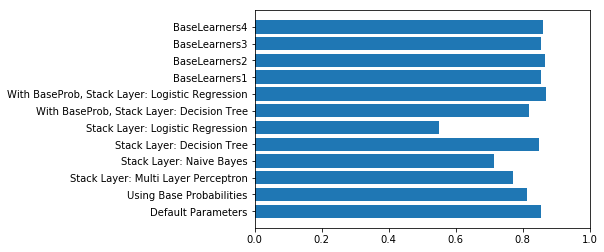

In [70]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(SuperLearner_Accuracy_comparisons)), list(SuperLearner_Accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(SuperLearner_Accuracy_comparisons)), list(SuperLearner_Accuracy_comparisons.keys()))

## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

Analyse the strength and correlation of the default base Classifiers

The performance of an ensemble relies on the strength of the individual estimators and the diversity between them. Ideally, we would like to have strong individual accuracy while also having diverse predictions, i.e., each classifier of the ensemble makes mistakes with different predictions. This helps the classifiers to learn from each others mistakes while good individual accuracy helps strengthen the learning. 
In the ensemble strength measuring function used here, accuracy of each classifier in the ensemble has been calculated by using cross-fold validation on the training set. To measure diversity, Euclidean distance between pairs of confusion matrices of each classifier's prediction on the hold-out data set has been used. The rationale behind this is, if the classifiers are weakly correlated, their confusion matrices will be very different from each other. Moreover, the number of correct predictions for each label will also differ for them. So as a measure of overall diversity, pair-wise Euclidean Distance between confusion matrices have been calculated. Also, to measure the diversity of correct predictions, which are present in the diagonals of the confusion matrix, Euclidean distance between the diagonals of every confusion matrix has also been calculated.

In [60]:
sl=SuperLearnerClassifier()
ensemble_accuracy, matrix_diversity, diagonal_diversity=sl.get_ensemble_strength(X,Y)

print("Base Estimator Accuracies:")
display(ensemble_accuracy)
print("---------------------------")
print("Overall diversity:")
print(pd.DataFrame(matrix_diversity))
print("---------------------------")
print("Diversity of correct predictions:")
print(pd.DataFrame(diagonal_diversity))
        

Base Estimator Accuracies:


{'Classifier0': 0.67095286330129356,
 'Classifier1': 0.81861813748799206,
 'Classifier2': 0.82762748767048555,
 'Classifier3': 0.84479703541037421,
 'Classifier4': 0.7552591981790524,
 'Classifier5': 0.49665405405697233}

---------------------------
Overall diversity:
     0          1          2          3          4           5
0  0.0  72.111026  71.958321  73.402997  61.122827  164.383697
1  0.0   0.000000  14.696938  13.341664  34.176015  179.320941
2  0.0   0.000000   0.000000  15.033296  36.878178  180.122181
3  0.0   0.000000   0.000000   0.000000  34.234486  181.653516
4  0.0   0.000000   0.000000   0.000000   0.000000  163.713164
5  0.0   0.000000   0.000000   0.000000   0.000000    0.000000
---------------------------
Diversity of correct predictions:
     0          1          2          3          4           5
0  0.0  57.236352  57.297469  59.084685  45.044423  105.242577
1  0.0   0.000000  11.357817   7.937254  25.238859  132.037873
2  0.0   0.000000   0.000000   7.615773  26.832816  133.719856
3  0.0   0.000000   0.000000   0.000000  26.832816  136.180028
4  0.0   0.000000   0.000000   0.000000   0.000000  114.468336
5  0.0   0.000000   0.000000   0.000000   0.000000    0.000000


Analyse the strength and correlation of a less diverse set of base Classifiers

In [64]:
sl=SuperLearnerClassifier(baseClassifiers=[DecisionTreeClassifier(criterion="entropy",max_depth=24,min_samples_split=200),\
                                          DecisionTreeClassifier(criterion="entropy",max_depth=24,min_samples_split=200),\
                         GaussianNB()],stackClassifier=MLPClassifier(alpha=0.1,hidden_layer_sizes=(400, 200, 100)))
ensemble_accuracy, matrix_diversity, diagonal_diversity=sl.get_ensemble_strength(X,Y)

print("Base Estimator Accuracies:")
display(ensemble_accuracy)
print("---------------------------")
print("Overall diversity:")
print(pd.DataFrame(matrix_diversity))
print("---------------------------")
print("Diversity of correct predictions:")
print(pd.DataFrame(diagonal_diversity))
        

Base Estimator Accuracies:


{'Classifier0': 0.67095286330129356,
 'Classifier1': 0.67142679695058261,
 'Classifier2': 0.49665405405697233}

---------------------------
Overall diversity:
     0    1           2
0  0.0  0.0  164.383697
1  0.0  0.0  164.383697
2  0.0  0.0    0.000000
---------------------------
Diversity of correct predictions:
     0    1           2
0  0.0  0.0  105.242577
1  0.0  0.0  105.242577
2  0.0  0.0    0.000000


Analyse diversity of another configuration

In [63]:
sl=SuperLearnerClassifier(baseClassifiers=[DecisionTreeClassifier(criterion="entropy",max_depth=24,min_samples_split=200),\
                                          DecisionTreeClassifier(criterion="entropy",max_depth=24,min_samples_split=200),\
                         GaussianNB(),MLPClassifier(alpha=0.1,hidden_layer_sizes=(400, 200, 100))])
ensemble_accuracy, matrix_diversity, diagonal_diversity=sl.get_ensemble_strength(X,Y)

print("Base Estimator Accuracies:")
display(ensemble_accuracy)
print("---------------------------")
print("Overall diversity:")
print(pd.DataFrame(matrix_diversity))
print("---------------------------")
print("Diversity of correct predictions:")
print(pd.DataFrame(diagonal_diversity))
        

Base Estimator Accuracies:


{'Classifier0': 0.67142679695058261,
 'Classifier1': 0.67142679695058261,
 'Classifier2': 0.49665405405697233,
 'Classifier3': 0.82052749962786531}

---------------------------
Overall diversity:
     0    1           2           3
0  0.0  0.0  164.383697   70.512410
1  0.0  0.0  164.383697   70.512410
2  0.0  0.0    0.000000  186.150477
3  0.0  0.0    0.000000    0.000000
---------------------------
Diversity of correct predictions:
     0    1           2           3
0  0.0  0.0  105.242577   54.230987
1  0.0  0.0  105.242577   54.230987
2  0.0  0.0    0.000000  136.546695
3  0.0  0.0    0.000000    0.000000
